In [1]:
import re
from os import makedirs
from typing import Final, TypeAlias

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from nltk.corpus import gutenberg
from pandas import DataFrame

from authorship_tool.types import Para2dStr, Tag
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import ParagraphFeatureDatasetGenerator
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.lgbm import trainer as lgbm_trainer
from authorship_tool.util.lgbm.model import LGBMResultModel, LGBMSourceModel
from authorship_tool.util.path_util import PathUtil

# 必要に応じてダウンロード
nltk.download("gutenberg")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

Project root: /workspaces/shap-authorship-analysis-demo
Path: path_dump_lgbm_model_dir = /workspaces/shap-authorship-analysis-demo/dump/lgbm/model
Path: path_dump_dataset_dir = /workspaces/shap-authorship-analysis-demo/dump/dataset
Path: path_dump_shap_figure_dir = /workspaces/shap-authorship-analysis-demo/dump/shap/figure
Path: path_adjective_past_participle_dataset = /workspaces/shap-authorship-analysis-demo/data/nlp_datasets/wordLists/adjectivesPastParticiple


[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "austen"
DESIRED_ROC_SCORE: Final[float] = 0.9


In [3]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [4]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(iterable=authors):
    books: list[list[Para2dStr]] = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in books for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [5]:
books_a: list[list[Para2dStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]  # type: ignore

paras_a: list[Para2dStr] = [para for paras in books_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:10]:
    print(dim_reshaper.para_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [6]:
books_b: list[list[Para2dStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]  # type: ignore

paras_b: list[Para2dStr] = [para for paras in books_b for para in paras]
if len(paras_b) == 0 or not type_guard.are_paras(paras_b):
    raise ValueError("paras_a is empty or not list[list[str]]")

for para in paras_b[:10]:
    print(dim_reshaper.para_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

[ Emma by Jane Austen 1816 ]
VOLUME I
CHAPTER I
Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .
She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of gover

In [7]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(paras_b)):
    raise TypeError("paras_a or paras_b is not list[Para]")
all_paras: list[Para2dStr] = paras_a + paras_b

pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list

print(pos_list)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [8]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=pos_list)
data: list[tuple[float, ...]] = []
correctness: list[bool] = []

for para_a in paras_a:
    (x, y) = dataset_generator.generate_from_paragraph(para_a, True)
    data.append(x)
    correctness.append(y)

for para_b in paras_b:
    (x, y) = dataset_generator.generate_from_paragraph(para_b, False)
    data.append(x)
    correctness.append(y)


In [9]:
df = DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

pd.set_option("display.max_columns", 1000)
display(df.head(10))
pd.reset_option("display.max_columns")


,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains although,v13 contains however,v14 contains but,v15 contains because,v16 contains this,v17 contains others or researchers,v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains et,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,1,14,False,False,False,False,False,0.000000,0.000000,False,False,False,False,False,False,False,False,True,True,False,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,2,8,False,False,False,False,False,2.000000,4.000000,True,False,False,False,False,False,False,False,False,True,False,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,5,164,False,False,True,False,False,12.983066,13.250000,False,True,False,False,False,False,False,False,False,False,False,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.048780,0.006098,0.134146,0.000000,0.006098,0.176829,0.073171,0.006098,0.000000,0.0,0.000000,0.164634,0.012195,0.000000,0.036585,0.000000,0.000000,0.060976,0.000000,0.036585,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.042683,0.018293,0.012195,0.012195,0.024390,0.006098,0.0,0.000000,0.000000,0.0
3,6,149,False,True,True,False,False,4.669642,6.200000,False,False,False,False,True,False,True,False,False,False,False,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.013423,0.013423,0.013423,0.120805,0.000000,0.000000,0.100671,0.053691,0.000000,0.006711,0.0,0.006711,0.127517,0.013423,0.000000,0.046980,0.013423,0.000000,0.046980,0.013423,0.060403,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.020134,0.087248,0.006711,0.067114,0.013423,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,8,294,True,False,True,False,False,18.699933,22.857143,False,True,False,True,True,False,False,False,True,False,False,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.037415,0.010204,0.088435,0.003401,0.000000,0.115646,0.105442,0.000000,0.000000,0.0,0.003401,0.122449,0.010204,0.003401,0.034014,0.003401,0.000000,0.064626,0.020408,0.091837,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.023810,0.068027,0.006803,0.030612,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,5,91,False,True,False,False,False,13.511477,15.250000,True,True,False,False,False,False,True,False,False,False,False,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.076923,0.000000,0.000000,0.131868,0.054945,0.000000,0.000000,0.0,0.010989,0.142857,0.054945,0.000000,0.065934,0.000000,0.000000,0.054945,0.021978,0.054945,0.000000,0.000000,0.000000,0.0,0.054945,0.0,0.054945,0.010989,0.032967,0.010989,0.021978,0.032967,0.010989,0.0,0.000000,0.000000,0.0
6,1,50,False,False,True,True,False,0.000000,0.000000,False,True,False,False,True,False,True,False,False,True,False,0.0,0.0,0.000000,0.000000,0.040000,0.000000,0.020000,0.020000,0.000000,0.060000,0.000000,0.000000,0.180000,0.020000,0.000000,0.000000,0.0,0.040000,0.140000,0.020000,0.000000,0.060000,0.000000,0.000000,0.160000,0.020000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.080000,0.040000,0.000000,0.000000,0.0600

In [10]:
print(df.shape)


(9320, 64)


In [11]:
print(df.dtypes)


v1 sentences per paragraph          int64
v2 words per paragraph              int64
v3 close parenthesis present         bool
v4 dash present                      bool
v5 semi-colon or colon present       bool
                                   ...   
WDT                               float64
WP                                float64
WP$                               float64
WRB                               float64
``                                float64
Length: 64, dtype: object


In [12]:
print(df.isna().sum())


v1 sentences per paragraph        0
v2 words per paragraph            0
v3 close parenthesis present      0
v4 dash present                   0
v5 semi-colon or colon present    0
                                 ..
WDT                               0
WP                                0
WP$                               0
WRB                               0
``                                0
Length: 64, dtype: int64


In [13]:
result: LGBMResultModel = lgbm_trainer.learn_until_succeed(
    LGBMSourceModel(DESIRED_ROC_SCORE, df, nd_correctness)
)


[LightGBM] [Info] Number of positive: 3081, number of negative: 3909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9626
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.440773 -> initscore=-0.238027
[LightGBM] [Info] Start training from score -0.238027


In [14]:
print(f"auc-roc score: {result.auc_roc_score}")


auc-roc score: 0.9092337349251634


In [15]:
display(result.pred_crosstab())


col_0,False,True
row_0,,
False,1165,191
True,202,772


In [16]:
result.dump("gutenberg")


In [17]:
explainer = shap.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    PathUtil.DATASET_DIR.joinpath("test_shap_val.csv"), index=False, header=False
)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [18]:
shap.initjs()


In [19]:
makedirs(PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg"), exist_ok=True)

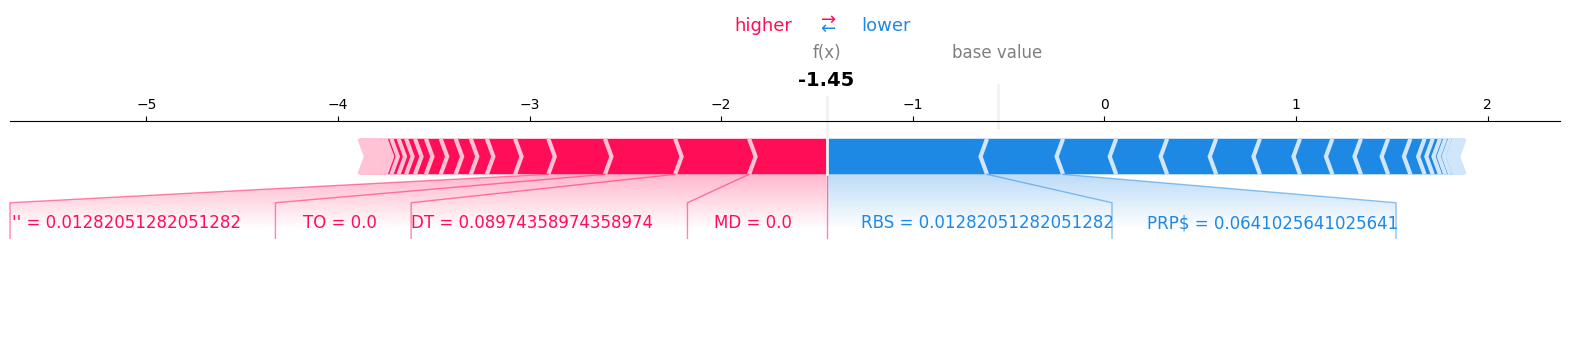

<Figure size 640x480 with 0 Axes>

In [20]:
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
)
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


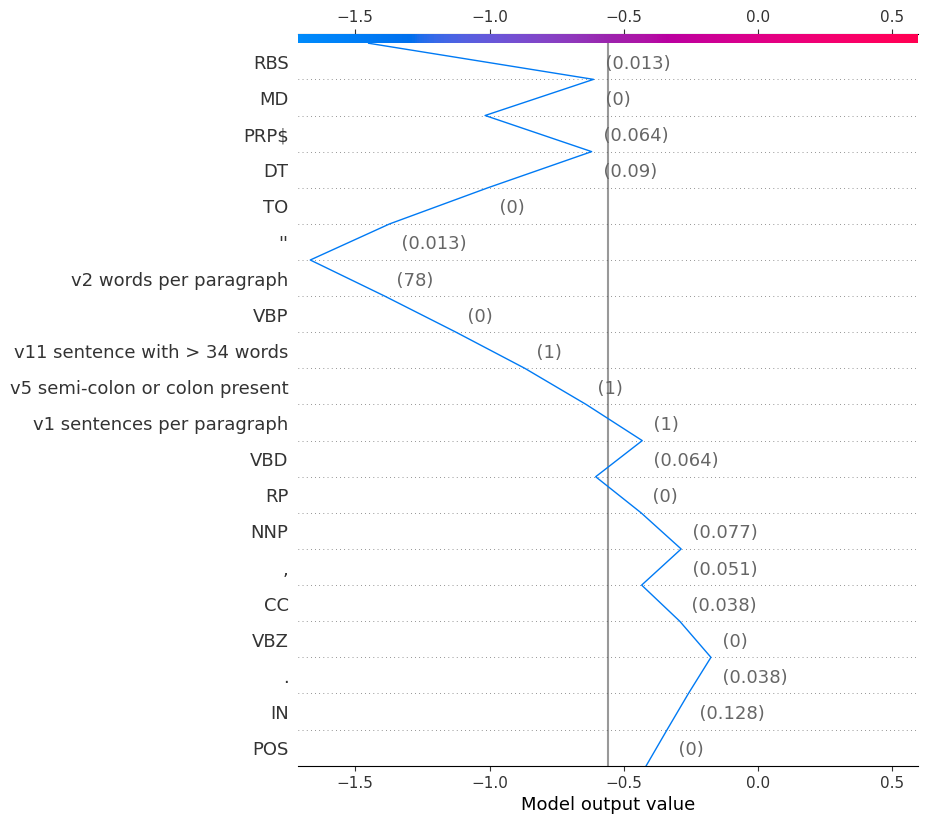

<Figure size 640x480 with 0 Axes>

In [21]:
shap.decision_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()



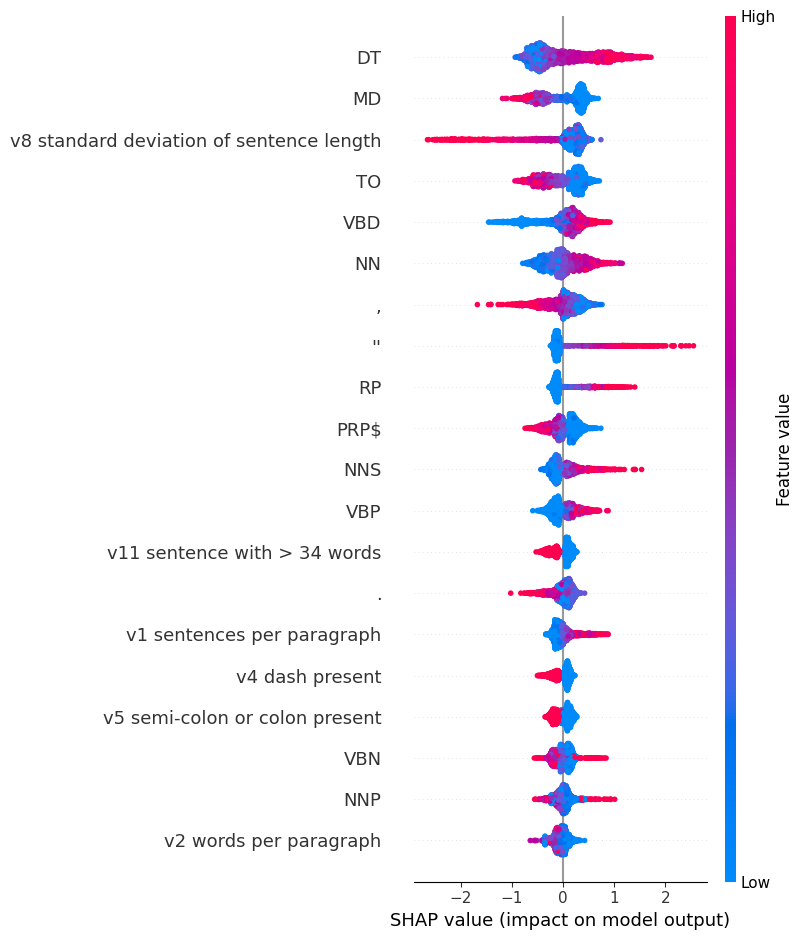

<Figure size 640x480 with 0 Axes>

In [22]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


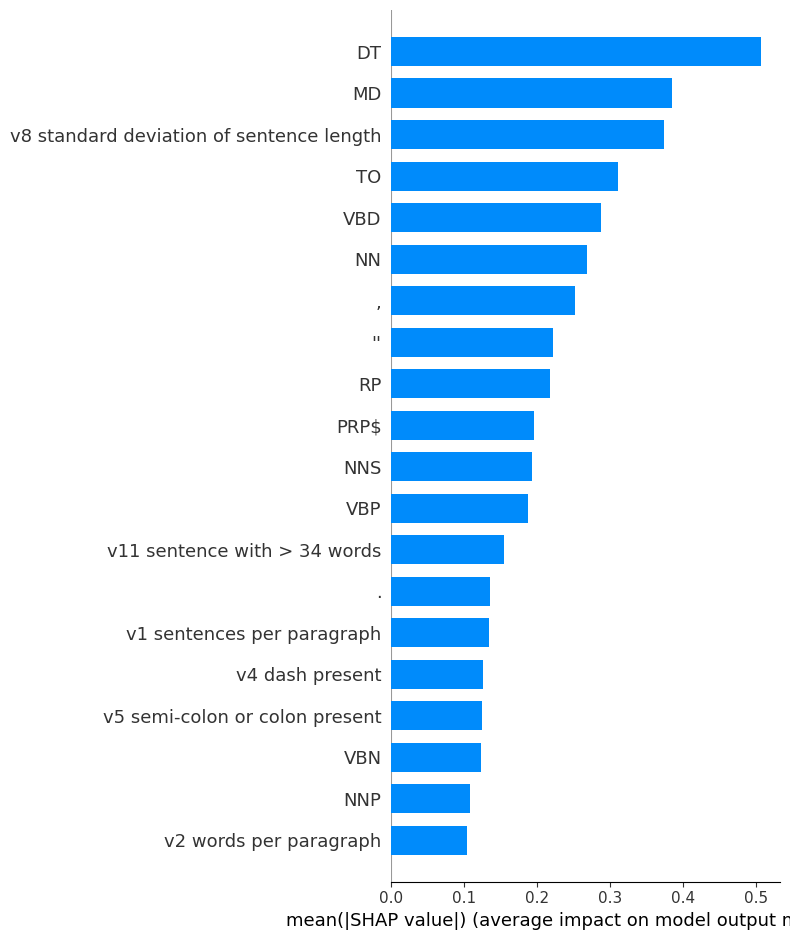

<Figure size 640x480 with 0 Axes>

In [23]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
